In [2]:
import pandas as pd
import json

In [3]:
import gc
import os
import random

import numpy as np
import torch
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             confusion_matrix,
                             cohen_kappa_score)
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, AutoConfig, AutoModel
from scipy import sparse

In [4]:
train = pd.read_json('arr.json')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         684 non-null    object
 1   domain     684 non-null    object
 2   sentences  684 non-null    object
 3   labels     684 non-null    object
dtypes: object(4)
memory usage: 21.5+ KB


,id,domain,sentences,labels
0,a47173d3ddf05abf2848f8d8f4b62e27a29d96f9ee08c4...,arr,"[This paper compares two figures, Firth and Ha...","[Recap, Recap, Strengths, Strengths, Strengths..."
1,a4d284a7d3c4ce822d168c01f209a7b5eaa16a30952d0d...,arr,[This paper advocates the importance of cultur...,"[Recap, Recap, Recap, Strengths, Strengths, St..."
2,3d9bd4f696a0ffd93f440373203719609023010bd34a2c...,arr,[The paper proposes to trace an agenda for cro...,"[Recap, Recap, Recap, Recap, Recap, Recap, Rec..."
3,747249d6df576d913b4dd001992510d9682657fee6f4ea...,arr,[Some prior art focuses on detecting adversari...,"[Recap, Recap, Recap, Recap, Strengths, Streng..."
4,58ef2606ffcc1a9d790427b7220378a346d698c7023beb...,arr,[The paper explores the task of detecting of a...,"[Recap, Recap, Recap, Strengths, Strengths, St..."


Transform data into sequence tagging task

In [5]:
essay_id = []
label = []
text = []
prediction_string = []
domain = []
for index, row in train.iterrows():
    sentences = row['sentences']
    essay_id.extend([row['id']]*len(sentences))
    domain.extend([row['domain']]*len(sentences))
    count_t = 0
    for i in range(len(sentences)):
        text.append(sentences[i])
        label.append(row['labels'][i])
        token_indexes = []
        for t in sentences[i].split():
            token_indexes.append(count_t)
            count_t+=1
        prediction_string.append(' '.join( [str(x) for x in token_indexes]))
df = pd.DataFrame(list(zip(essay_id, domain, label, text, prediction_string)),columns =['essay_id', 'domain', 'label', 'text', 'prediction_string'])

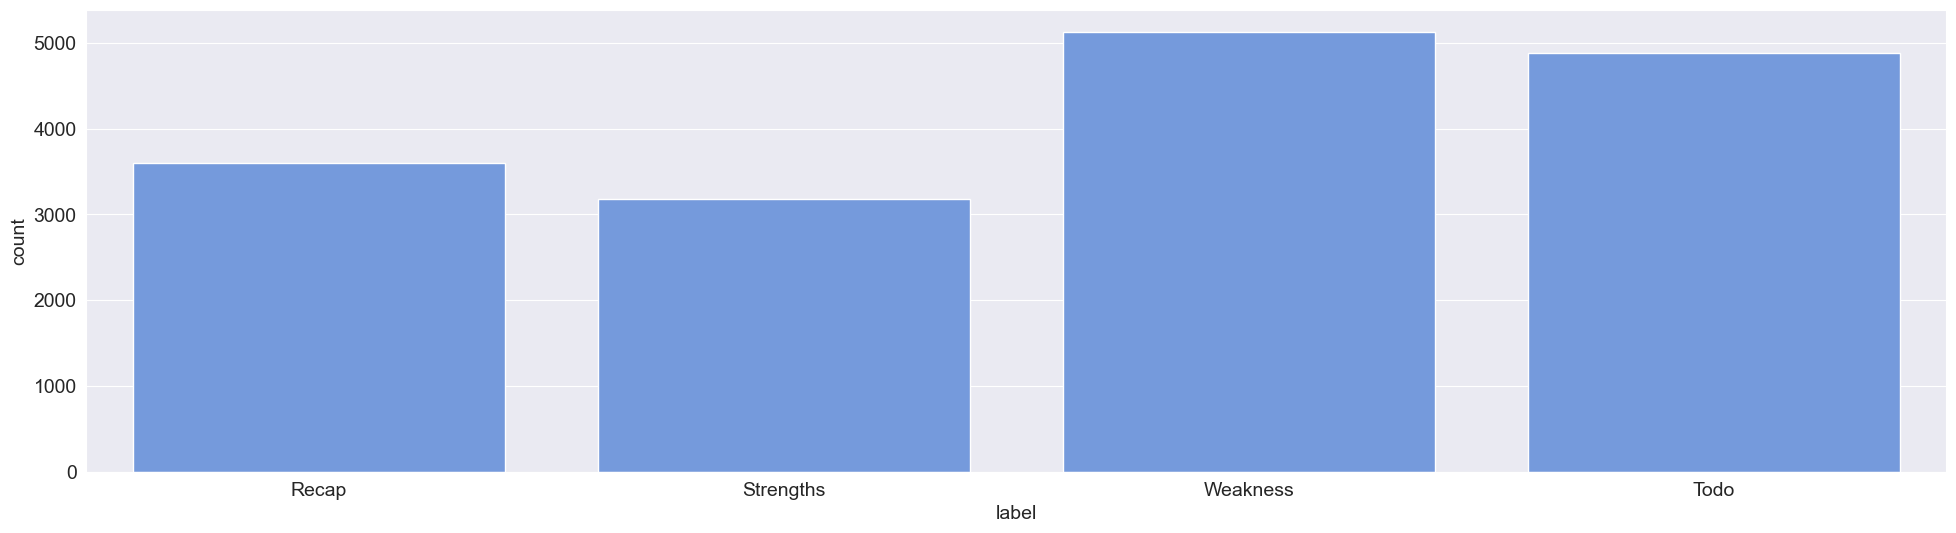

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rc('legend',fontsize=10)
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
sns.countplot(data = df, x = "label", ax = ax, color='cornflowerblue')
plt.show()

In [7]:
temp = df.groupby(["essay_id"]).label.value_counts().to_frame()
temp.columns = ['amount']
temp.reset_index(drop = False, inplace=True)
temp = temp.pivot(index="essay_id", columns = "label").amount
temp

label,Recap,Strengths,Todo,Weakness
essay_id,,,,
007b93f0c37668d86e7d736d9a0361f703c7f0aab6f5722e8556663989d187c59735da6e1a2e6615a11597e3e1eb415b46c6507923c698e896ef29f8ba3c3b42,3.0,4.0,9.0,9.0
00b1d8296a836fe8f6dda3d7c4b42674cca6f332f0c1865c4dc68f83e4c18995ed83391dbadb2f207e1f0ecfd02e512dba8c30173297edb4d698ee7451fbd19c,1.0,1.0,9.0,1.0
0113a9cd1e940411099dd650e752e34811f84ffc8cc9edb39dd3714c0e4bfad9b97c1d84f1d0c9d051f46de849a337f834dc3be749bb6d4afa3bc0393cd0ae18,4.0,4.0,1.0,11.0
01a966ca7689800bb527da97e4518d9ec6c5d42ac4708085dd24321b2ec88f0e7c02384976698b0fa9684b1f31edc56366599541f0bfdc819906d0ee7f5c0533,5.0,7.0,58.0,7.0
01ad9f64bb9ed7914538870cdbbd3c82e95fd62891aeda62db93ea449a649b1916a0f16d79ed40e9d1b75779c062c3bccb0255f2af2ca8a5f383eb7dfc4839a8,4.0,2.0,9.0,1.0
...,...,...,...,...
fd35e7df6ba77a0794a94b00ec6cfb948a3ee80b9591adacc34966a10018c2a1af14748f9d8f4a54eb5db32f8acbd46ffd0035b600b6aa71551cbe78e7238a79,2.0,3.0,25.0,4.0
fd6f572f1c5279528023a42eb9fbdad249b1f1ebfe7c12bbfa276ed59b3018998128a948f482055f07ab0c3ba4b83416a21640418e95a7517111b6d650e0a6f1,6.0,7.0,9.0,15.0
fd73ac3f95e24da9f049c742dbf2f0c7ce752be24db2bccaeb657520e3dd1d7e9cc23e31cc970c9436553cd5d2b36b63826a9bd7b216c718fd2600a0508eaf1d,3.0,3.0,9.0,14.0


In [8]:
temp.mean()

label
Recap        5.267544
Strengths    4.641813
Todo         7.152269
Weakness     7.501462
dtype: float64

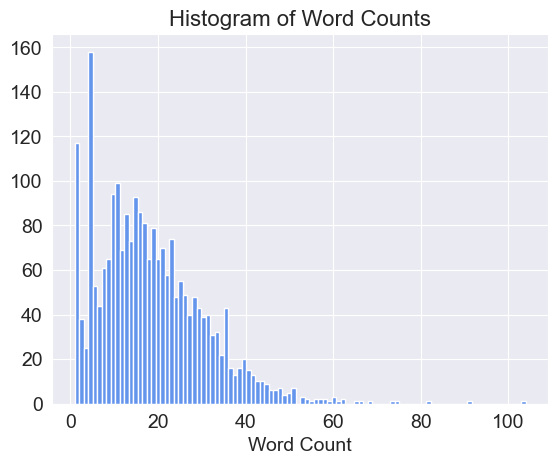

In [12]:
df["discourse_num_words"] = df.text.apply(lambda x: len(x.split()))
plt.hist(df["discourse_num_words"], bins=100, color='cornflowerblue')
plt.title('Histogram of Word Counts',size=16)
plt.xlabel('Word Count',size=14)
plt.show()